# Prepare Packages and Check GPU

In [ ]:
!pip install gitpython

In [ ]:
import os
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cm
import tqdm
from scipy.interpolate import UnivariateSpline
import skimage
from skimage.io import imread
from skimage.data import coffee, camera
from skimage.filters import gaussian, roberts

%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# sklearn
from sklearn.model_selection import train_test_split

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image as Image_Ip

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.6.0
keras version 2.6.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi

Thu Oct  7 16:21:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    35W / 250W |   8335MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mount Drive and Read in Pictures

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/AC 215 Final Project/Code/')

Mounted at /content/drive


In [ ]:
!pwd

/content/drive/.shortcut-targets-by-id/1dm6hDrNl7Mx-WuobdY1NWuJ13Jgf5sRw/AC 215 Final Project/Code


In [ ]:
import glob
from PIL import Image

image_list = []

for filename in glob.glob('img/*.png'): 
    im=Image.open(filename)
    image_list.append(np.array(im))

In [ ]:
image_list[0].shape

(1024, 1024, 3)

# Import Model and Segment Image

In [ ]:
# from git import Repo
# Repo.clone_from('https://github.com/bonlime/keras-deeplab-v3-plus.git', 'deeplab/')

In [ ]:
from deeplab.model import Deeplabv3

deeplab_model = Deeplabv3(input_shape=(1024, 1024, 3), classes=2)  

8986624/8986568 [==============================] - 0s 0us/step


In [ ]:
trained_image_width=512 
mean_subtraction_value=127.5
image = image_list[7]
image = image

# resize to max dimension of images from training dataset
w, h, _ = image.shape
ratio = float(trained_image_width) / np.max([w, h])
resized_image = np.array(Image.fromarray(image.astype('uint8')).resize((int(ratio * h), int(ratio * w))))

# apply normalization for trained dataset images
resized_image = (resized_image / mean_subtraction_value) - 1.

# pad array to square image to match training images
pad_x = int(trained_image_width - resized_image.shape[0])
pad_y = int(trained_image_width - resized_image.shape[1])
resized_image = np.pad(resized_image, ((0, pad_x), (0, pad_y), (0, 0)), mode='constant')

# make prediction
deeplab_model = Deeplabv3()
res = deeplab_model.predict(np.expand_dims(resized_image, 0))
labels = np.argmax(res.squeeze(), -1)

# remove padding and resize back to original image
if pad_x > 0:
    labels = labels[:-pad_x]
if pad_y > 0:
    labels = labels[:, :-pad_y]
labels = np.array(Image.fromarray(labels.astype('uint8')).resize((h, w)))
# plt.waitforbuttonpress()

In [ ]:
deeplab_model.summary()

Model: "deeplabv3plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 256, 256, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
Conv_BN (BatchNormalization)    (None, 256, 256, 32) 128         Conv[0][0]                       
__________________________________________________________________________________________________
Conv_Relu6 (Activation)         (None, 256, 256, 32) 0           Conv_BN[0][0]                    
______________________________________________________________________________________

In [ ]:
labels[labels>0] = 1

<Figure size 432x288 with 0 Axes>

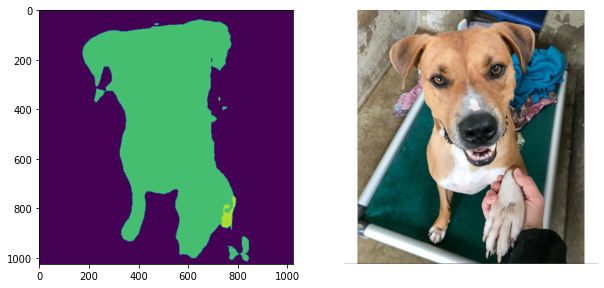

In [ ]:
plt.figure()
f, ax = plt.subplots(1,2, figsize = (10,5)) 

ax[0].imshow(labels)
ax[1].imshow(image)
plt.axis('off')
plt.show()

# Remove Background Based on Label

<Figure size 432x288 with 0 Axes>

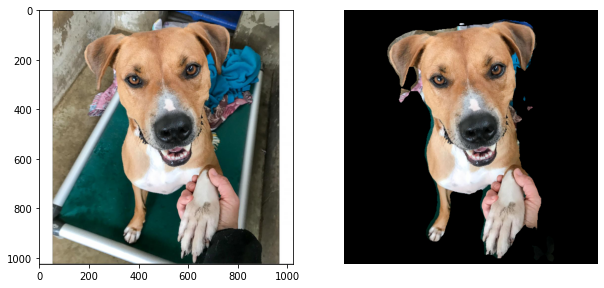

In [ ]:
img_bgrm = np.multiply(np.dstack((labels, labels, labels)),image)

plt.figure()
f, ax = plt.subplots(1,2, figsize = (10,5)) 
ax[0].imshow(image)
ax[1].imshow(img_bgrm)
plt.axis('off')
plt.show()

# Add Color to Background

<Figure size 432x288 with 0 Axes>

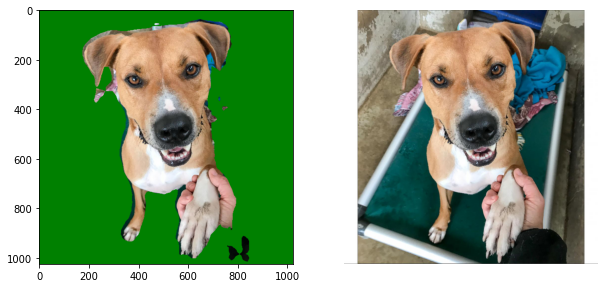

In [ ]:
color_name = 'green'
colored_original_image = np.zeros((1024, 1024, 3), np.uint8)
c = tuple([255*x for x in colors.to_rgb(color_name)])
colored_original_image[:] = c
mapping = cv2.cvtColor(labels * 255, cv2.COLOR_GRAY2RGB)
layered_image_color = np.where(mapping != (0,0,0), 
                         image, 
                         colored_original_image)

plt.figure()
f, ax = plt.subplots(1,2, figsize = (10,5)) 
ax[0].imshow(layered_image_color)
ax[1].imshow(image)
plt.axis('off')
plt.show()

# Blur Background Based on Label

From: https://www.analyticsvidhya.com/blog/2020/10/how-to-get-background-blur-using-deep-learning/

<Figure size 432x288 with 0 Axes>

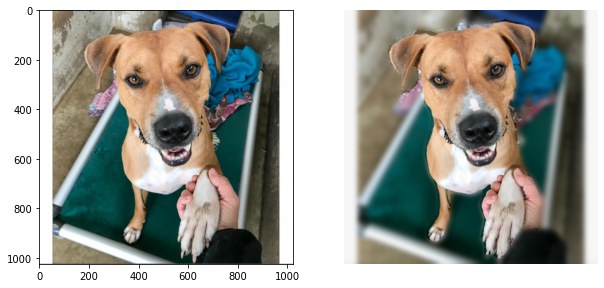

In [ ]:
blurred_original_image = cv2.GaussianBlur(image,(251,251),10)
mapping = cv2.cvtColor(labels * 255, cv2.COLOR_GRAY2RGB)
layered_image_blur = np.where(mapping != (0,0,0), 
                         image, 
                         blurred_original_image)

plt.figure()
f, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(image) 
ax[1].imshow(layered_image_blur)
plt.axis('off')
plt.show()

# Add Filter to Image

## Adjust Image Temperature

In [ ]:
def spreadLookupTable(x, y):
  spline = UnivariateSpline(x, y)
  return spline(range(256))
  
def warmImage(image):
    increaseLookupTable = spreadLookupTable([0, 64, 128, 256], [0, 80, 160, 256])
    decreaseLookupTable = spreadLookupTable([0, 64, 128, 256], [0, 50, 100, 256])
    red_channel, green_channel, blue_channel = cv2.split(image)
    red_channel = cv2.LUT(red_channel, increaseLookupTable).astype(np.uint8)
    blue_channel = cv2.LUT(blue_channel, decreaseLookupTable).astype(np.uint8)
    return cv2.merge((red_channel, green_channel, blue_channel))

def coldImage(image):
    increaseLookupTable = spreadLookupTable([0, 64, 128, 256], [0, 80, 160, 256])
    decreaseLookupTable = spreadLookupTable([0, 64, 128, 256], [0, 50, 100, 256])
    red_channel, green_channel, blue_channel = cv2.split(image)
    red_channel = cv2.LUT(red_channel, decreaseLookupTable).astype(np.uint8)
    blue_channel = cv2.LUT(blue_channel, increaseLookupTable).astype(np.uint8)
    return cv2.merge((red_channel, green_channel, blue_channel))

<Figure size 432x288 with 0 Axes>

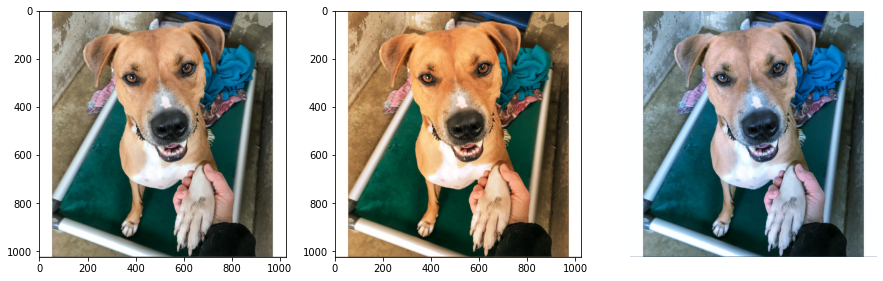

In [ ]:
plt.figure()
f, ax = plt.subplots(1,3, figsize = (15,5)) 
ax[0].imshow(image)
ax[1].imshow(warmImage(image))
ax[2].imshow(coldImage(image))
plt.axis('off')
plt.show()

## Oil Painting Effect

<Figure size 432x288 with 0 Axes>

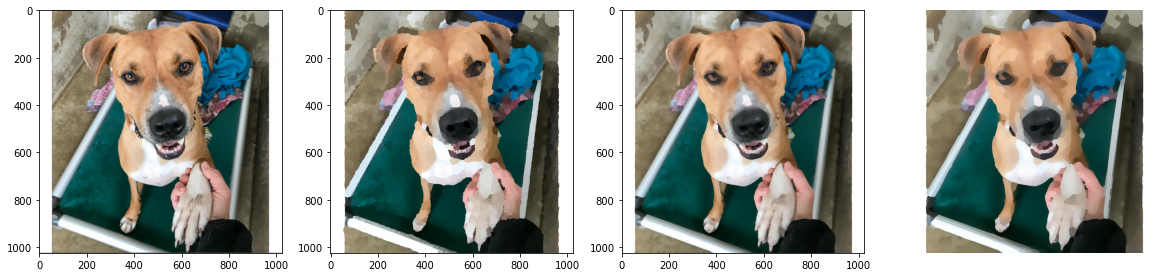

In [ ]:
plt.figure()
f, ax = plt.subplots(1,4, figsize = (20,5)) 
ax[0].imshow(image)
ax[1].imshow(cv2.xphoto.oilPainting(src=image, size=10, dynRatio=1))
ax[2].imshow(cv2.xphoto.oilPainting(src=image, size=5, dynRatio=50))
ax[3].imshow(cv2.xphoto.oilPainting(src=image, size=10, dynRatio=50))
plt.axis('off')
plt.show()

## Watercolor Effect

<Figure size 432x288 with 0 Axes>

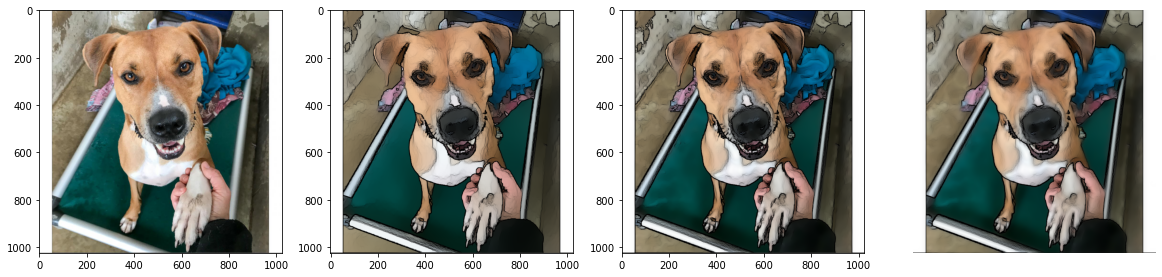

In [ ]:
plt.figure()
f, ax = plt.subplots(1,4, figsize = (20,5)) 
ax[0].imshow(image)
ax[1].imshow(cv2.stylization(image, sigma_s = 50, sigma_r = 0.5))
ax[2].imshow(cv2.stylization(image, sigma_s = 10, sigma_r = 0.5))
ax[3].imshow(cv2.stylization(image, sigma_s = 10, sigma_r = 1))
plt.axis('off')
plt.show()

<Figure size 432x288 with 0 Axes>

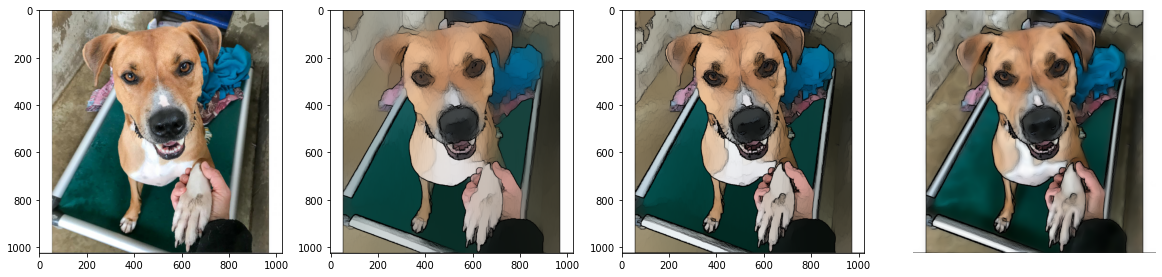

In [ ]:
plt.figure()
f, ax = plt.subplots(1,4, figsize = (20,5)) 
ax[0].imshow(image)
ax[1].imshow(cv2.stylization(image, sigma_s = 1000, sigma_r = 1))
ax[2].imshow(cv2.stylization(image, sigma_s = 1000, sigma_r = 0.5))
ax[3].imshow(cv2.stylization(image, sigma_s = 10, sigma_r = 1))
plt.axis('off')
plt.show()

<Figure size 432x288 with 0 Axes>

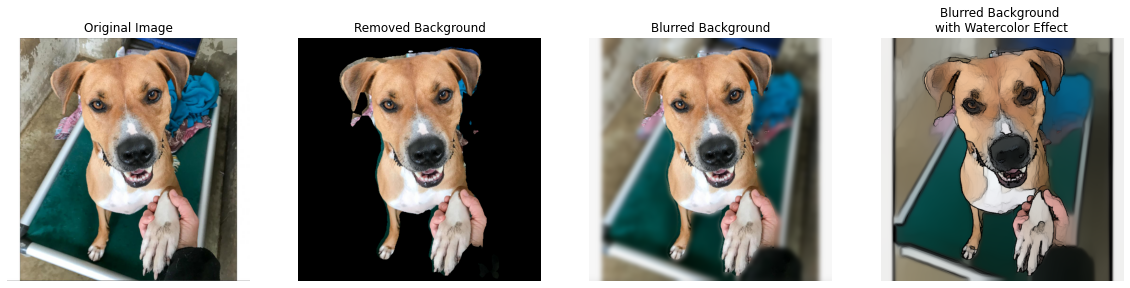

In [ ]:
plt.figure()
f, ax = plt.subplots(1,4, figsize = (20,5)) 
ax[0].imshow(image)
ax[1].imshow(img_bgrm)
ax[2].imshow(layered_image_blur)
ax[3].imshow(cv2.stylization(layered_image_blur, sigma_s = 100, sigma_r = 0.5))
ax[0].set_title('Original Image')
ax[1].set_title('Removed Background')
ax[2].set_title('Blurred Background')
ax[3].set_title('Blurred Background \nwith Watercolor Effect')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')
plt.savefig('segmentation.png')
plt.show()